# Based on our custom MIMIC language model, train a classifier

Make sure mimic_nlp_lm has been run first and sucessfully completed. That notebook builds the language model that allows classificiation to occur efficiently.

## Create a classifier to predict Length of Stay (LOS)

Steps:
1. Load clinical Notes
1. Load Admissions data
1. Calculate Length of Stay
1. Join Admissions data with Notes data (on HADM_ID) - Columns needed for classifier: LOS, TEXT

Would also be nice to see a graphical summary of LOS.

In [1]:
from fastai.text import *
from sklearn.model_selection import train_test_split
import glob
import gc
import altair as alt

Setup filenames and paths

In [2]:
# pandas doesn't understand ~, so provide full path
base_path = Path.home() / 'mimic'

# files used during processing - all aggregated here
admissions_file = base_path/'ADMISSIONS.csv'
notes_file = base_path/'NOTEEVENTS.csv'

class_file = 'los_cl_data.pickle'
notes_pickle_file = base_path/'noteevents.pickle'
lm_file = 'mimic_lm.pickle' # actual file is at base_path/lm_file but due to fastai function, have to pass file name separately
init_model_file = base_path/'los_cl_head'
cycles_file = base_path/'los_cl_num_iterations.pickle'
enc_file = 'mimic_fine_tuned_enc'
ft_file = 'los_cl_fine_tuned_'
freeze_two = 'los_cl_freeze_two'
freeze_three = 'los_cl_freeze_three'

training_history_file = 'los_cl_history'

Setup parameters for models

In [3]:
# original data set too large to work with in reasonable time due to limted GPU resources
pct_data_sample = 0.1
# how much to hold out for validation
valid_pct = 0.2
# for repeatability - different seed than used with language model
seed = 1776
# for language model building - not sure how this will translate to classifier
# batch size of 128 GPU uses 14GB RAM
# batch size of 96 GPU uses 9GB RAM
# batch size of 48 GPU uses 5GB RAM
bs=96

In [4]:
orig_df = pd.DataFrame()
if os.path.isfile(notes_pickle_file):
    print('Loading noteevent pickle file')
    orig_df = pd.read_pickle(notes_pickle_file)
    print(orig_df.shape)
else:
    print('Could not find noteevent pickle file; creating it')
    # run this the first time to covert CSV to Pickle file
    orig_df = pd.read_csv(notes_file, low_memory=False, memory_map=True)
    orig_df.to_pickle(notes_pickle_file)

Loading noteevent pickle file
(2083180, 11)


Since seed is different, this should be quite different than the language model dataset.

Should I show details on how many records are in language model dataset?

In [5]:
notes_df = orig_df[orig_df.HADM_ID.notnull()].copy()
notes_df.HADM_ID = notes_df.HADM_ID.astype(int)
notes_df.shape

(1851344, 11)

In [6]:
notes_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [7]:
print('Loading ADMISSIONS.csv')
a_orig = pd.read_csv(admissions_file, low_memory=False, memory_map=True)
a_orig.shape

Loading ADMISSIONS.csv


(58976, 19)

In [8]:
a_df = a_orig[['HADM_ID', 'ADMITTIME', 'DISCHTIME']].copy()
#pd.to_datetime('2014-04-09T152959.999993-0500', utc=True)
# passing format just to make sure conversion doesn't mess something up
a_df['admittime'] = pd.to_datetime(a_df.ADMITTIME, format='%Y-%m-%d %H:%M:%S')
a_df['dischtime'] = pd.to_datetime(a_df.DISCHTIME, format='%Y-%m-%d %H:%M:%S')
a_df['los'] = (a_df['dischtime'] - a_df['admittime']).astype('timedelta64[D]')
# there are 98 admissions where length of stay is negative. change to 0
a_df.loc[a_df.los < 0, 'los'] = 0
a_df.head()

,HADM_ID,ADMITTIME,DISCHTIME,admittime,dischtime,los
0,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,2196-04-09 12:26:00,2196-04-10 15:54:00,1.0
1,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,2153-09-03 07:15:00,2153-09-08 19:10:00,5.0
2,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,2157-10-18 19:34:00,2157-10-25 14:00:00,6.0
3,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,2139-06-06 16:14:00,2139-06-09 12:48:00,2.0
4,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,2160-11-02 02:06:00,2160-11-05 14:55:00,3.0


### Histogram of Length of Stay

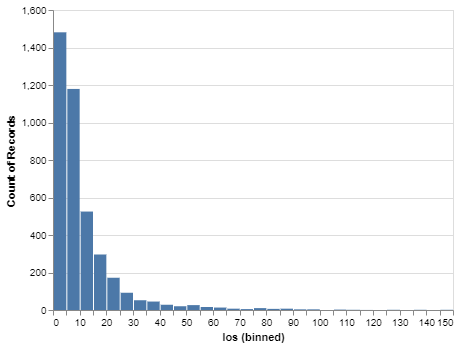

In [9]:
alt.Chart(a_df.head(4000)).mark_bar().encode(
    alt.X('los',
         bin=alt.BinParams(maxbins=50)),
    y='count()',
)

In [10]:
# make sure we only keep rows with notes
combined_df = pd.merge(a_df, notes_df, on='HADM_ID', how='right')

# passing format just to make sure conversion doesn't mess something up
combined_df['charttime'] = pd.to_datetime(combined_df.CHARTTIME, format='%Y-%m-%d %H:%M:%S')
combined_df['chartdate'] = pd.to_datetime(combined_df.CHARTDATE, format='%Y-%m-%d')
combined_df['admitdate'] = combined_df.admittime.dt.date
combined_df = combined_df[['HADM_ID', 'admittime', 'admitdate', 'dischtime', 'los', 'chartdate', 'charttime', 'TEXT']]
combined_df.rename(columns={"HADM_ID": "hadm_id", "TEXT": "text"}, inplace=True)
combined_df.shape

(1851344, 8)

In [11]:
# these should all be zero
print(combined_df[combined_df.los.isnull()].shape)
print(combined_df[combined_df.hadm_id.isnull()].shape)
print(combined_df[combined_df.text.isnull()].shape)

(0, 8)
(0, 8)
(0, 8)


In [12]:
combined_df.head()

,hadm_id,admittime,admitdate,dischtime,los,chartdate,charttime,text
0,165315,2196-04-09 12:26:00,2196-04-09,2196-04-10 15:54:00,1.0,2196-04-10,NaT,Admission Date: [**2196-4-9**] Discharg...
1,165315,2196-04-09 12:26:00,2196-04-09,2196-04-10 15:54:00,1.0,2196-04-09,NaT,Normal sinus rhythm. Non-diagnostic repolariza...
2,165315,2196-04-09 12:26:00,2196-04-09,2196-04-10 15:54:00,1.0,2196-04-09,NaT,Normal sinus rhythm without diagnostic abnorma...
3,165315,2196-04-09 12:26:00,2196-04-09,2196-04-10 15:54:00,1.0,2196-04-10,2196-04-10 23:52:00,[**2196-4-10**] 11:52 PM\n CHEST (PORTABLE AP)...
4,165315,2196-04-09 12:26:00,2196-04-09,2196-04-10 15:54:00,1.0,2196-04-09,2196-04-09 10:19:00,[**2196-4-9**] 10:19 AM\n CT HEAD W/O CONTRAST...


In [13]:
len(combined_df.hadm_id.unique())

58361

### Use notes from day 1 of stay to predict LOS


    For each admission
        do they have notes on day 1 of stay


In [14]:
combined_df.dtypes

hadm_id               int64
admittime    datetime64[ns]
admitdate            object
dischtime    datetime64[ns]
los                 float64
chartdate    datetime64[ns]
charttime    datetime64[ns]
text                 object
dtype: object

In [15]:
combined_df[combined_df.hadm_id == 100006].sort_values(['chartdate', 'charttime'])

,hadm_id,admittime,admitdate,dischtime,los,chartdate,charttime,text
305523,100006,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12.0,2108-04-06,2108-04-06 11:45:00,[**2108-4-6**] 11:45 AM\n CHEST (PORTABLE AP) ...
305532,100006,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12.0,2108-04-06,2108-04-06 18:04:00,PMICU Nursing Progress Notet 1630-1900\n\nPlea...
305519,100006,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12.0,2108-04-06,NaT,Sinus tachycardia\nLeft axis deviation - anter...
305535,100006,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12.0,2108-04-07,2108-04-07 04:01:00,Resp Care\nPt. appeared very uncomfortable @ s...
305536,100006,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12.0,2108-04-07,2108-04-07 05:07:00,7p to 7a Micu Progress Note\n\nNeuro - Remains...
305537,100006,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12.0,2108-04-07,2108-04-07 18:06:00,NARRATIVE NURSING NOTE\nRESP: PT HAS HAD 2 EPI...
305533,100006,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12.0,2108-04-08,2108-04-08 05:09:00,7p to 7a Micu Progress Note\n\nNeuro - Alert a...
305534,100006,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12.0,2108-04-08,2108-04-08 16:48:00,NARRATIVE NURSING NOTE:\nRESP; PT WITH EXP WHE...
305526,100006,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12.0,2108-04-09,2108-04-09 05:09:00,7p to 7a Micu Progress Note\n\nNeuro - Alert a...
305527,100006,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12.0,2108-04-09,2108-04-09 06:30:00,Addendum - Pt increasingly fatigued appearing ...


In [16]:
h = 100006
#for h in combined_df.HADM_ID.unique():
combined_df[(combined_df.hadm_id == h) & 
            (combined_df.charttime >= combined_df.admittime) &
            (combined_df.charttime < (combined_df.admittime + pd.Timedelta(hours=24)))
           ]

,hadm_id,admittime,admitdate,dischtime,los,chartdate,charttime,text
305532,100006,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12.0,2108-04-06,2108-04-06 18:04:00,PMICU Nursing Progress Notet 1630-1900\n\nPlea...
305535,100006,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12.0,2108-04-07,2108-04-07 04:01:00,Resp Care\nPt. appeared very uncomfortable @ s...
305536,100006,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12.0,2108-04-07,2108-04-07 05:07:00,7p to 7a Micu Progress Note\n\nNeuro - Remains...


In [17]:
h = 100006
#for h in combined_df.HADM_ID.unique():
combined_df[(combined_df.hadm_id == h) & 
            (((combined_df.charttime >= combined_df.admittime) &
            (combined_df.charttime < (combined_df.admittime + pd.Timedelta(hours=24))))
             |
            (combined_df.chartdate == combined_df.admitdate))
           ]

,hadm_id,admittime,admitdate,dischtime,los,chartdate,charttime,text
305519,100006,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12.0,2108-04-06,NaT,Sinus tachycardia\nLeft axis deviation - anter...
305523,100006,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12.0,2108-04-06,2108-04-06 11:45:00,[**2108-4-6**] 11:45 AM\n CHEST (PORTABLE AP) ...
305532,100006,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12.0,2108-04-06,2108-04-06 18:04:00,PMICU Nursing Progress Notet 1630-1900\n\nPlea...
305535,100006,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12.0,2108-04-07,2108-04-07 04:01:00,Resp Care\nPt. appeared very uncomfortable @ s...
305536,100006,2108-04-06 15:49:00,2108-04-06,2108-04-18 17:18:00,12.0,2108-04-07,2108-04-07 05:07:00,7p to 7a Micu Progress Note\n\nNeuro - Remains...


In [18]:
# Combine notes into one text field - need just one row for each patient
f_df = combined_df[(combined_df.hadm_id == h) & 
            (((combined_df.charttime >= combined_df.admittime) &
            (combined_df.charttime < (combined_df.admittime + pd.Timedelta(hours=24))))
             |
            (combined_df.chartdate == combined_df.admitdate))
           ]

In [19]:
fday = combined_df.groupby('hadm_id', as_index=False).apply(lambda g: g[
    (g.charttime >= g.admittime) & (g.charttime < (g.admittime + pd.Timedelta(hours=24)))
    |
    (g.chartdate == g.admitdate)
])

In [20]:
combined_fday = fday.groupby(['hadm_id', 'los'], as_index=False).agg({
    'text': lambda x: "\n\n\n\n".join(x)
})

In [21]:
combined_fday.head()

,hadm_id,los,text
0,100001,6.0,[**2117-9-11**] 11:12 AM\n CHEST (PA & LAT) ...
1,100003,4.0,Sinus rhythm\nProlonged QT interval is nonspec...
2,100006,12.0,Sinus tachycardia\nLeft axis deviation - anter...
3,100007,7.0,Sinus rhythm\nAtrial premature complex\nConsid...
4,100009,4.0,Sinus bradycardia. Left atrial abnormality. ...


In [22]:
combined_fday.shape

(55353, 3)

In [24]:
len(combined_fday.los.unique())

159

In [29]:
print(combined_fday.los.value_counts().head(10))
print(combined_fday.los.value_counts().tail(10))

4.0    5686
2.0    5389
3.0    4863
5.0    4554
6.0    4001
7.0    3503
1.0    3257
8.0    2825
9.0    2392
0.0    2062
Name: los, dtype: int64
155.0    1
167.0    1
141.0    1
109.0    1
153.0    1
181.0    1
142.0    1
202.0    1
140.0    1
103.0    1
Name: los, dtype: int64


In [26]:
s = combined_fday.los.value_counts()
len(s[s == 1])

23

### Truncate LOS to max of 10

In [31]:
combined_fday[combined_fday.los > 9] = 10

In [32]:
s = combined_fday.los.value_counts()
len(s[s == 1])

0

In [35]:
print(combined_fday.los.value_counts().head(15))

10.0    16821
4.0      5686
2.0      5389
3.0      4863
5.0      4554
6.0      4001
7.0      3503
1.0      3257
8.0      2825
9.0      2392
0.0      2062
Name: los, dtype: int64


### Histogram of number of notes by Hospital Admission - 10% random sample

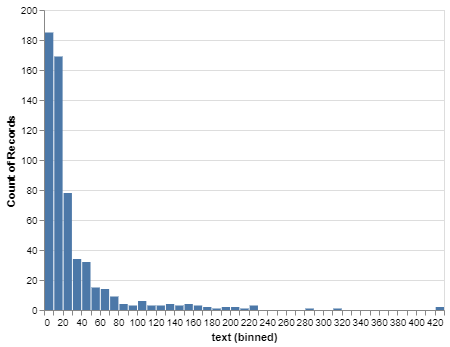

In [39]:
alt.Chart(
    combined_df.groupby('hadm_id', as_index=False).text.count().sample(frac=.01, random_state=seed)
).mark_bar().encode(
    alt.X('text', bin=alt.BinParams(maxbins=50)),
    y='count()',
)

### Scatter plot of Number of Notes vs Length of Stay

In [41]:
combined_df[['hadm_id', 'los']].drop_duplicates().shape            #42,195
combined_df.groupby('hadm_id', as_index=False).text.count().shape  #42,195

(58361, 2)

In [42]:
los_v_num_notes = pd.merge(combined_df[['hadm_id', 'los']].drop_duplicates(), 
          combined_df.groupby('hadm_id', as_index=False).text.count(),
          on='hadm_id')
los_v_num_notes.shape

(58361, 3)

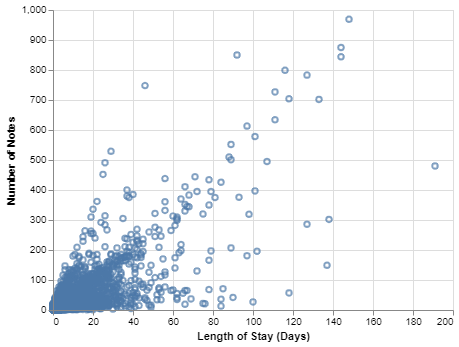

In [47]:
alt.Chart(los_v_num_notes.sample(frac=.08, random_state=seed)).mark_point().encode(
    x=alt.X('los', axis=alt.Axis(title='Length of Stay (Days)')),
    y=alt.Y('text', axis=alt.Axis(title='Number of Notes')))

### Continuing on with Deep Learning

In [ ]:
df = combined_fday.sample(frac=pct_data_sample, random_state=seed)

In [ ]:
if os.path.isfile(base_path/lm_file):
    print('loading existing language model')
    lm = load_data(base_path, lm_file, bs=bs)
else:
    print('ERROR: language model file not found.')

#### This is a very CPU and RAM intensive process - no GPU involved

In [ ]:
filename = base_path/class_file
if os.path.isfile(filename):
    data_cl = load_data(base_path, class_file, bs=bs)
    print('loaded existing data bunch')
else:
    # do I need a vocab here? test with and without...
    data_cl = (TextList.from_df(df, base_path, cols='text', vocab=lm.vocab)
               #df has several columns; actual text is in column TEXT
               .split_by_rand_pct(valid_pct=valid_pct, seed=seed)
               #We randomly split and keep 20% for validation, set seed for repeatability
               .label_from_df(cols='los')
               .databunch(bs=bs))
    data_cl.save(filename)
    print('created new data bunch')

### Using weighted F1 to account for class imbalance

See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

In [ ]:
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(average='weighted', beta=1)])
learn.load_encoder(enc_file)

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

Change learning rate based on results from the above plot

In [ ]:
if os.path.isfile(str(init_model_file) + '.pth'):
    learn.load(init_model_file)
    print('loaded initial learner')
else:
    print('Training new initial learner')
    learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))
    print('Saving new learner')
    learn.save(init_model_file)
    print('Finished generating new learner')

In [ ]:
if os.path.isfile(str(freeze_two) + '.pth'):
    learn.load(freeze_two)
    print('loaded freeze_two learner')
else:
    print('Training new freeze_two learner')
    learn.freeze_to(-2)
    learn.fit_one_cycle(1, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7))
    print('Saving new freeze_two learner')
    learn.save(freeze_two)
    print('Finished generating new freeze_two learner')

In [ ]:
if os.path.isfile(str(freeze_three) + '.pth'):
    learn.load(freeze_three)
    print('loaded freeze_three learner')
else:
    print('Training new freeze_three learner')
    learn.freeze_to(-3)
    learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
    print('Saving new freeze_three learner')
    learn.save(freeze_three)
    print('Finished generating new freeze_three learner')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
release_mem()

In [ ]:
if os.path.isfile(cycles_file):
    with open(cycles_file, 'rb') as f:
        prev_cycles = pickle.load(f)
    print('This model has been trained for', prev_cycles, 'epochs already')  
else:
    prev_cycles = 0

In [ ]:
num_cycles = 7

file = descr_ft_file + str(prev_cycles)
learner_file = base_path/file
callback_save_file = str(learner_file) + '_auto'

learn.fit_one_cycle(num_cycles, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7),
                    callbacks=[
                        callbacks.SaveModelCallback(learn, every='epoch', monitor='accuracy', name=callback_save_file),
                        # CSVLogger only logs when num_cycles are complete
                        callbacks.CSVLogger(learn, filename=training_history_file, append=True)
                    ])
file = descr_ft_file + str(prev_cycles + num_cycles)
learner_file = base_path/file
learn.save(learner_file)

with open(cycles_file, 'wb') as f:
    pickle.dump(num_cycles + prev_cycles, f)
release_mem()